# SNN with CODEnn Dataset


In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import random
import numpy as np
import tables
from tqdm import tqdm
from tensorflow.keras.losses import cosine_similarity

In [2]:
# All load_hdf5(), pad(), load_pickle() functions obtained from Deep Code search repository
def load_hdf5(vecfile, start_offset, chunk_size):
    """reads training sentences(list of int array) from a hdf5 file"""  
    table = tables.open_file(vecfile)
    data = table.get_node('/phrases')[:].astype(np.int)
    index = table.get_node('/indices')[:]
    data_len = index.shape[0]
    if chunk_size==-1:#if chunk_size is set to -1, then, load all data
        chunk_size=data_len
    start_offset = start_offset%data_len    
    sents = []
    for offset in tqdm(range(start_offset, start_offset+chunk_size)):
        offset = offset%data_len
        len, pos = index[offset]['length'], index[offset]['pos']
        sents.append(data[pos:pos + len])
    table.close()
    return sents

def pad(data, len=None):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    return pad_sequences(data, maxlen=len, padding='post', truncating='post', value=0)

import pickle

def load_pickle(filename):
    return pickle.load(open(filename, 'rb'))   

In [3]:
data_path = "../data/codenn/dummy/"

file_format = "h5"

# 18223872 (len) #1000000
train_tokens = load_hdf5( data_path+"train.tokens."+file_format, 0, 1000)
train_desc = load_hdf5( data_path+"train.desc."+file_format, 0, 1000)
# Negative sampling
train_bad_desc = load_hdf5( data_path+"train.desc."+file_format, 0, 1000)
random.shuffle(train_bad_desc)
vocabulary_tokens = load_pickle(data_path+"vocab.tokens.pkl")
vocabulary_desc = load_pickle(data_path+"vocab.desc.pkl")

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 499797.90it/s]


In [4]:
code_vector = train_tokens
desc_vector = train_desc
bad_desc_vector = train_bad_desc

longer_code = max(len(t) for t in code_vector)
longer_desc = max(len(t) for t in desc_vector)

longer_sentence = max(longer_code, longer_desc)

code_vector = pad(code_vector, longer_sentence)
desc_vector = pad(desc_vector, longer_sentence)
bad_desc_vector = pad(bad_desc_vector, longer_sentence)

number_desc_tokens = len(vocabulary_desc)
number_code_tokens = len(vocabulary_tokens)
print(longer_sentence, number_code_tokens, number_desc_tokens)

46 10001 10001


A this point we have 2 different vocabularies that we need to merge

In [5]:
vocabulary_desc["widget"]

1197

In [6]:
vocabulary_tokens["widget"]

746

In [7]:
merged_vocabulary = { "<s>":0, "</s>":0,  "UNK": 1, }

In [8]:
count = 2
for word in vocabulary_desc:
    if not word in  merged_vocabulary:
        merged_vocabulary[word] = count
        count+=1
    
for word in vocabulary_tokens:
    if not word in  merged_vocabulary:
        merged_vocabulary[word] = count
        count+=1
        
len(merged_vocabulary)

13645

In [9]:
inversed_vocabulary_desc = dict((y,x) for x,y in vocabulary_desc.items())
inversed_vocabulary_tokens = dict((y,x) for x,y in vocabulary_tokens.items())

In [10]:
for idx, element in enumerate(code_vector):
    for idxx, num in enumerate(element):
        code_vector[idx,idxx] = merged_vocabulary[inversed_vocabulary_tokens[num]]
    
    if idx % 100000 == 0:
        print(idx, "/", len(code_vector))

0 / 1000


In [11]:
for idx, element in enumerate(desc_vector):
    for idxx, num in enumerate(element):
        desc_vector[idx,idxx] = merged_vocabulary[inversed_vocabulary_desc[num]]
    
    if idx % 100000 == 0:
        print(idx, "/", len(desc_vector))

0 / 1000


(None, 46, 512)


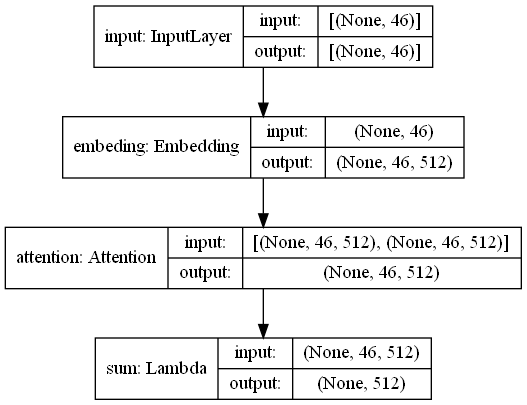

In [12]:
embedding_size = 512
longer_input_size = longer_sentence
number_of_tokens = len(merged_vocabulary)

input_layer = tf.keras.Input(shape=(longer_input_size,), name="input")
embeding_layer = tf.keras.layers.Embedding(number_of_tokens, embedding_size, name="embeding")(input_layer)

attention_layer = tf.keras.layers.Attention(name="attention")([embeding_layer, embeding_layer])

print(attention_layer.shape)

sum_layer = tf.keras.layers.Lambda(lambda x: K.sum(x, axis=1), name="sum")( attention_layer)
#average_layer = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name="average")( attention_layer)

model = tf.keras.Model(inputs=[input_layer], outputs=[sum_layer], name='embedding_model')

tf.keras.utils.plot_model(model, "embedding_model.png", show_shapes=True, expand_nested=True)

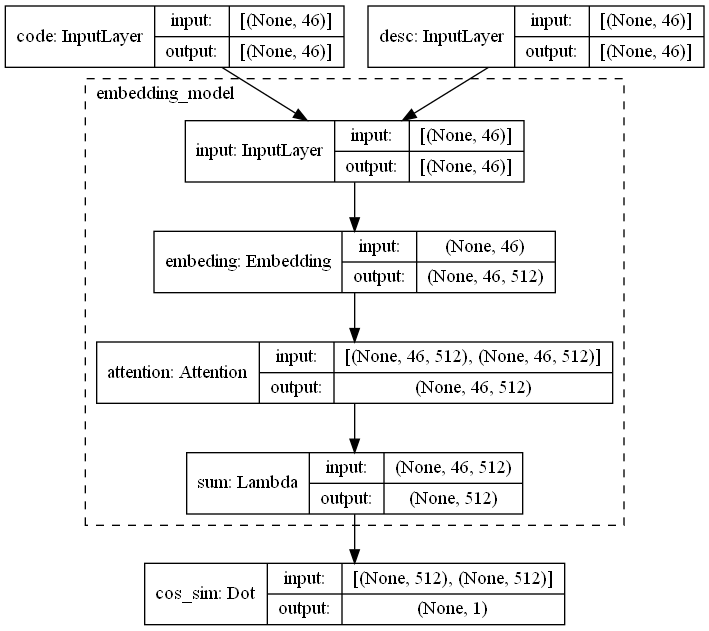

In [13]:
input_code = tf.keras.Input(shape=(longer_sentence,), name="code")
input_desc = tf.keras.Input(shape=(longer_sentence,), name="desc")

output_code = model(input_code)
output_desc = model(input_desc)

cos_sim = tf.keras.layers.Dot(axes=1, normalize=True, name='cos_sim')([output_code, output_desc]) 

cos_model = tf.keras.Model(inputs=[input_code, input_desc], outputs=[cos_sim],name='snn_model')  

tf.keras.utils.plot_model(cos_model, "snn_model.png", show_shapes=True, expand_nested=True)

In [20]:

#code_vector
#desc_vector
negative_description_vector = desc_vector
random.shuffle(negative_description_vector)

positive_results = np.ones((len(desc_vector),1))
negative_results = np.zeros((len(negative_description_vector), 1))

extended_code_vector = []
extended_code_vector.extend(code_vector)
extended_code_vector.extend(code_vector)

extended_desc_vector = []
extended_desc_vector.extend(desc_vector)
extended_desc_vector.extend(negative_description_vector)

result_vector = np.concatenate((positive_results, negative_results), axis=0)

print(len(extended_code_vector), len(extended_desc_vector), result_vector.shape)

2000 2000 (2000, 1)


In [25]:

cos_model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

cos_model.fit(x=[np.array(extended_code_vector), np.array(extended_desc_vector)], y=result_vector, epochs=10, verbose=1, batch_size=64)

Epoch 1/10
32/32 [==============================] - 5s 95ms/step - loss: 0.7221 - accuracy: 0.4364
Epoch 2/10
32/32 [==============================] - 3s 96ms/step - loss: 0.7140 - accuracy: 0.4414
Epoch 3/10
32/32 [==============================] - 3s 94ms/step - loss: 0.7092 - accuracy: 0.4493
Epoch 4/10
32/32 [==============================] - 3s 95ms/step - loss: 0.7098 - accuracy: 0.4665
Epoch 5/10
32/32 [==============================] - 3s 99ms/step - loss: 0.7052 - accuracy: 0.4800
Epoch 6/10
32/32 [==============================] - 3s 100ms/step - loss: 0.7069 - accuracy: 0.4531
Epoch 7/10
32/32 [==============================] - 3s 99ms/step - loss: 0.7081 - accuracy: 0.4694
Epoch 8/10
32/32 [==============================] - 3s 102ms/step - loss: 0.7073 - accuracy: 0.4504
Epoch 9/10
32/32 [==============================] - 3s 99ms/step - loss: 0.7147 - accuracy: 0.4373
Epoch 10/10
32/32 [==============================] - 3s 99ms/step - loss: 0.7008 - accuracy: 0.4981
